In [3]:
import os
import random

import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from tqdm.notebook import tqdm

import pandas as pd
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, f1_score, accuracy_score, recall_score, classification_report
import warnings
warnings.filterwarnings("ignore")

# Ensure deterministic behavior
torch.backends.cudnn.deterministic = True
random.seed(hash("setting random seeds") % 2**32 - 1)
np.random.seed(hash("improves reproducibility") % 2**32 - 1)
torch.manual_seed(hash("by removing stochasticity") % 2**32 - 1)
torch.cuda.manual_seed_all(hash("so runs are repeatable") % 2**32 - 1)

# Device configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
!pip install adabound
from adabound import AdaBound

In [ ]:
%%capture
!pip install wandb --upgrade

In [ ]:
#Connect to Weights & Biases tool

import wandb

wandb.login()

True

In [ ]:
#Weights & Biases parameters used for experimentation 
#Commented out parameter range once finalised

import math
import pprint

sweep_config = {
    'method': 'random'
    }

metric = {
    'name': 'loss',
    'goal': 'minimize'   
    }

sweep_config['metric'] = metric

parameters_dict = {
    'optimizer': {
        # 'values': ['adam', 'sgd', 'adaBound']
        'values': ['adaBound']
        
        },
    'epochs': {
        'values': [120]
        
        },
    'n_neurons': {
        'values': [400]
        
        },
     'learning_rate': {
        'values': [0.01765]
        
        },
    }

# sweep_config['parameters'] = parameters_dict
# parameters_dict.update({
#     'epochs': {
#         'distribution': 'int_uniform',
#         'min': 280,
#         'max': 280  
#               }
#     })

# parameters_dict.update({
#     'learning_rate': {
#         # a flat distribution between 0 and 0.1
#         'distribution': 'uniform',
#         'min': 0.001,
#         'max': 0.1
#       }
#     })

# parameters_dict.update({
#     'n_neurons': {
#         # a flat distribution between 0 and 0.1
#         'distribution': 'int_uniform',
#         'min': 10,
#         'max': 2000
#       }
#     })

sweep_config['parameters'] = parameters_dict


pprint.pprint(sweep_config)
sweep_id = wandb.sweep(sweep_config, project="pytorchcnn_Test15")

{'method': 'random',
 'metric': {'goal': 'minimize', 'name': 'loss'},
 'parameters': {'epochs': {'values': [120]},
                'learning_rate': {'values': [0.01765]},
                'n_neurons': {'values': [400]},
                'optimizer': {'values': ['adaBound']}}}
Create sweep with ID: nommejsk
Sweep URL: https://wandb.ai/georgequine/pytorchcnn_Test15/sweeps/nommejsk


In [1]:
#Connect to google drive
from google.colab import drive
drive.mount('/content/drive',force_remount=False)

Mounted at /content/drive


In [4]:
#laod training data
df = pd.read_csv('/content/drive/MyDrive/Masters Final Code/Training Data /full_dataset.csv')
df.head()

,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023,1024,1025,1026,1027,1028,1029,1030,1031,1032,1033,1034,1035,1036,1037,1038,1039,1040,...,12962,12963,12964,12965,12966,12967,12968,12969,12970,12971,12972,12973,12974,12975,12976,12977,12978,12979,12980,12981,12982,12983,12984,12985,12986,12987,12988,12989,12990,12991,12992,12993,12994,12995,12996,12997,12998,12999,13000,label
0,59.266940,58.975565,56.977616,55.014508,53.877194,53.220730,50.860882,47.463943,44.173050,40.728620,37.778277,34.656815,30.961166,28.576316,25.705487,23.429298,20.835799,18.086858,15.982501,14.069913,12.669504,11.605206,11.241240,11.183826,10.949130,11.554249,12.700787,13.914162,15.318965,16.672831,17.866379,19.045740,20.124406,21.208071,22.141830,22.676671,23.277050,23.543391,23.519463,23.260488,...,34.735554,34.765562,34.678664,34.512007,34.322563,34.103119,33.842738,33.493695,33.197472,32.807479,32.425769,32.041632,31.645223,31.282365,30.997365,30.771227,30.586665,30.418362,30.329322,30.428226,30.579591,30.771811,31.007821,31.259095,31.511969,31.808180,32.068951,32.377991,32.599538,32.812502,32.972029,33.047066,33.044833,32.958811,32.751570,32.525590,32.321445,32.090483,31.853165,anticlockwise
1,9.430219,6.761833,9.067841,12.187881,14.981282,16.715642,19.715080,23.163117,25.447648,27.718549,30.377929,32.616499,34.647300,36.321364,37.409992,38.749442,39.357017,40.390042,40.389234,39.849927,39.231486,38.059002,36.888366,35.158190,33.319958,31.756469,30.249104,28.391213,26.696637,25.092950,23.396958,21.607635,20.131839,19.009112,18.332633,17.719721,17.272350,17.154719,17.396746,17.995878,...,30.017048,30.265275,30.600462,30.848805,31.067650,31.200203,31.212855,31.137469,30.994356,30.755191,30.530855,30.300401,29.958972,29.662847,29.243039,28.907576,28.483592,28.041963,27.617938,27.291661,27.000971,26.829175,26.650888,26.527821,26.522587,26.673186,26.940109,27.132103,27.410858,27.685320,27.858208,28.118958,28.397762,28.634164,28.792600,28.979371,29.104917,29.082998,28.982344,anticlockwise
2,2.868740,2.638707,-0.119674,-0.770817,-0.523272,0.400442,1.812526,2.644360,4.213869,5.531512,7.156005,8.800867,10.671912,13.126050,15.357117,17.718541,19.743324,21.475337,23.093008,25.120537,26.951150,27.875134,28.923155,29.700597,30.265234,30.548805,30.301771,29.617393,28.597515,27.448084,26.425182,25.307582,23.913099,22.815762,21.488140,20.367087,19.073577,17.700016,16.588129,15.796413,...,34.881854,35.148785,35.417311,35.545756,35.606420,35.621083,35.593693,35.447691,35.215229,34.900662,34.608659,34.327760,33.992264,33.643252,33.272813,32.825891,32.368992,32.017913,31.710410,31.475204,31.266631,31.121929,31.078878,31.165161,31.332728,31.504093,31.739346,31.957377,32.201025,32.468668,32.688856,32.929781,33.111370,33.276577,33.409469,33.469222,33.438192,33.278108,33.053418,anticlockwise
3,-23.941770,-24.585864,-23.475114,-20.766808,-17.370528,-14.256579,-11.572156,-8.461068,-3.922998,0.160036,4.051118,7.858369,10.914839,13.832789,16.368720,18.394049,20.390406,22.037248,23.101412,23.897198,24.110355,24.116469,23.503537,22.396112,21.447701,20.610410,19.732168,18.652795,17.841939,17.383684,17.067991,16.850357,16.726509,16.915540,17.232486,17.454309,18.071009,19.100583,20.086145,20.754245,...,30.892966,30.692160,30.469059,30.269131,30.062083,29.953660,29.854667,29.751801,29.729367,29.770015,29.794164,29.878503,30.013778,30.244121,30.562816,30.903089,31.163605,31.496989,31.860004,32.171123,32.417351,32.717307,32.927582,33.158691,33.281369,33.328732,33.239581,33.146154,32.939934,32.754137,32.531472,32.194415,31.838391,31.475434,31.081774,30.626135,30.198868,29.761125,29.450418,anticlockwise
4,17.395550,18.192997,16.825123,13.345473,9.850659,8.191031,5.703118,5.081544,3.776101,3.805677,4.666533,5.248170,6.371694,7.113687,8.597010,10.451168,12.147938,13.876962,16.093001,18.214960,20.409131,22.031014,23.802472,25.350971,26.595183,27.832736,28.788830,29.533239,29.645163,29.620110,29.254347,28.737529,27.991383,26

In [ ]:
lb = LabelEncoder()
df['label'] = lb.fit_transform(df['label'])

In [ ]:
df2 = df.transpose()
df2 = df2.head(df2.shape[0] -1)
df2.columns = df2.columns.map(str)
df2

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023,1024,1025,1026,1027,1028,1029,1030,1031,1032,1033,1034,1035,1036,1037,1038,1039,1040,1041,1042,1043,1044,1045,1046,1047,1048
1001,59.266940,9.430219,2.868740,-23.941770,17.395550,-7.461775,-2.029481,1.754814,5.493331,28.382210,34.730060,-17.883850,5.279702,34.989470,50.798050,52.186650,-8.316293,1.358074,-8.957183,52.690200,15.625480,31.434060,-1.968444,31.052580,8.560441,-7.889034,3.021332,51.774650,48.417610,-7.736442,43.534650,-7.553330,58.412420,13.916440,6.561479,50.584420,31.739250,16.647850,-6.469923,51.515240,...,-17.181920,3.326517,75.029750,-24.094360,78.539380,11.032440,-5.752738,76.204710,69.170200,57.847830,69.460120,83.925900,59.007530,85.833310,-11.352890,19.074070,-10.208440,65.157010,60.533460,-23.133030,13.626510,-16.968290,2.548295,8.270515,-8.163701,17.502370,73.931080,69.536420,-18.173770,68.971820,78.646190,54.399240,-25.147250,36.225470,-18.662070,91.036710,1.037629,84.933010,8.606219,46.845910
1002,58.975565,6.761833,2.638707,-24.585864,18.192997,-6.648991,-2.313188,-1.342967,3.929105,22.608374,38.540945,-22.009109,2.020898,36.492352,50.767382,45.868401,-8.791695,-3.342272,-9.187215,53.924717,10.810115,29.049381,-2.689215,24.672991,3.714407,-2.720954,-1.172941,48.055778,46.608017,-3.534501,41.648381,-11.985305,62.859731,17.765665,-0.178495,45.308994,32.766732,13.703421,-7.965139,54.758712,...,-13.409375,7.597467,80.519879,-18.642572,79.091462,13.095072,-5.775741,70.883275,72.582356,56.183927,66.047964,76.158441,61.990295,85.848641,-5.172661,11.544314,-15.330513,64.420908,64.252332,-22.343251,7.392611,-14.729301,1.881199,7.227698,-3.693388,14.450592,70.012851,70.011825,-23.978278,66.633150,74.720293,57.036958,-29.809259,27.415193,-12.627530,88.145958,2.187795,85.929819,5.201727,38.334681
1003,56.977616,9.067841,-0.119674,-23.475114,16.825123,-2.447986,-1.164512,-3.480060,2.596010,18.757314,39.816335,-24.072556,1.576836,37.414560,49.991692,45.493681,-11.215737,-0.331609,-11.955871,53.699174,8.121063,23.707948,-1.434490,22.150956,-2.134073,-3.428292,-4.189254,47.062791,43.919068,-4.286457,38.019421,-12.851234,63.746182,21.072818,0.564869,40.118817,35.554599,12.172280,-7.564489,52.562191,...,-16.770395,12.334671,81.887496,-12.047619,79.326856,17.224628,-0.050108,70.902467,70.986625,50.805320,59.393081,68.622091,64.895619,83.896417,-3.559604,9.347858,-13.184790,66.559285,67.413289,-22.639970,6.059632,-9.282305,4.468980,13.543268,-1.612536,10.643777,70.494622,69.528116,-29.221514,66.613953,74.464862,60.608145,-27.777328,21.899575,-8.093637,84.901419,4.682629,81.633310,2.772318,33.268080
1004,55.014508,12.187881,-0.770817,-20.766808,13.345473,1.638862,0.184243,-1.284267,0.225717,12.688600,40.349448,-22.715065,-1.948192,42.049902,49.100478,42.665473,-13.349286,0.089425,-13.402086,53.687087,6.211259,19.050913,-0.838137,19.654762,-4.368909,-2.678359,-5.279136,47.445317,42.206799,-3.523982,33.997865,-12.943420,65.176805,24.778593,-0.097352,36.071774,39.933950,9.664246,-8.239297,51.626619,...,-16.747040,21.038116,80.077557,-7.526685,79.119282,23.769467,4.446645,69.812348,68.674759,43.763770,53.362995,63.150325,70.142988,79.911632,-2.865410,6.743389,-9.207813,66.896570,68.881394,-20.360437,4.173424,-4.057485,9.584694,19.322391,-1.032957,4.655266,67.320190,70.908735,-31.622283,61.876367,72.660481,66.250384,-25.510685,17.608504,-5.795825,85.463163,7.947412,76.546145,-0.246783,28.307022
1005,53.877194,14.981282,-0.523272,-17.370528,9.850659,3.763922,2.198247,0.148309,-1.806550,10.205722,40.292598,-21.558175,-5.657022,44.687713,50.246907,38.885936,-15.843475,2.757865,-15.237960,52.157483,4.265363,15.596881,-0.819687,16.382625,-6.615662,-1.257114,-6.452925,45.856713,41.518844,-1.905307,28.462560,-10.651382,66.682665,27.839358,1.012127,32.812488,42.296764,8.906692,-11.377536,50.579657,...,-15.895581,28.793972,77.923842,-5.592603,78.182

In [ ]:
#NORMALISATION MIN MAX

from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler


Complete_x = []


for i in range(0,1049):
  x2 = df2.iloc[:-1 , :]

  x2 = df2.iloc[:, i].values
  y1 = df.loc[:,['label']].values

  x_data = x2
  x_data = np.array(x_data)
  x_data = x_data.reshape(-1,1)

  #array to hold normalised data
  data_array = []
  norm = []

  #MinMax done here, normalised data added to data array
  scaler2 = MinMaxScaler()
  norm = scaler2.fit_transform(x_data)
  data_array = norm
  data_array = data_array.flatten()

  # Initialise the dataframe with first gestrue
  if (i == 0):
    Complete_x = data_array
    normDF = pd.DataFrame(data = Complete_x, columns = [f'gesture{i}'])

  #further gestures are appended to the dataframe
  if (i > 0):
    Complete_x = data_array
    normDF[f'gesture{i}'] = Complete_x

normDF

,gesture0,gesture1,gesture2,gesture3,gesture4,gesture5,gesture6,gesture7,gesture8,gesture9,gesture10,gesture11,gesture12,gesture13,gesture14,gesture15,gesture16,gesture17,gesture18,gesture19,gesture20,gesture21,gesture22,gesture23,gesture24,gesture25,gesture26,gesture27,gesture28,gesture29,gesture30,gesture31,gesture32,gesture33,gesture34,gesture35,gesture36,gesture37,gesture38,gesture39,...,gesture1009,gesture1010,gesture1011,gesture1012,gesture1013,gesture1014,gesture1015,gesture1016,gesture1017,gesture1018,gesture1019,gesture1020,gesture1021,gesture1022,gesture1023,gesture1024,gesture1025,gesture1026,gesture1027,gesture1028,gesture1029,gesture1030,gesture1031,gesture1032,gesture1033,gesture1034,gesture1035,gesture1036,gesture1037,gesture1038,gesture1039,gesture1040,gesture1041,gesture1042,gesture1043,gesture1044,gesture1045,gesture1046,gesture1047,gesture1048
0,1.000000,0.830369,0.804591,0.723090,0.879138,0.819156,0.831295,0.839378,0.855903,0.948849,0.964412,0.781100,0.862683,0.949334,1.000000,1.000000,0.811939,0.857039,0.807940,0.995741,0.869962,0.937263,0.833598,0.946005,0.863990,0.806821,0.834689,1.000000,1.000000,0.800738,0.896450,0.716214,0.934907,0.820138,0.789518,0.948197,0.885029,0.823055,0.773499,0.978735,...,0.546268,0.588650,0.823434,0.513638,0.847647,0.656000,0.591364,0.865003,0.845438,0.796379,0.770040,0.842057,0.790666,0.862944,0.620981,0.719036,0.648596,0.830487,0.857581,0.594352,0.698627,0.601540,0.676663,0.682966,0.604520,0.701187,0.848882,0.826273,0.593596,0.808170,0.839571,0.768110,0.618104,0.738868,0.589837,0.821054,0.633328,0.801464,0.613196,0.733915
1,0.998999,0.820952,0.803786,0.720819,0.881928,0.822018,0.830338,0.828733,0.850357,0.927077,0.978567,0.765980,0.851128,0.954687,0.999889,0.978358,0.810168,0.840533,0.807128,1.000000,0.853205,0.929291,0.831078,0.922630,0.845989,0.825994,0.818970,0.986723,0.993287,0.816187,0.890131,0.701118,0.949176,0.833463,0.765935,0.929716,0.888523,0.812524,0.768338,0.990083,...,0.557473,0.602229,0.839823,0.530594,0.849403,0.662700,0.591289,0.848139,0.856647,0.791201,0.762825,0.825149,0.797444,0.862979,0.635208,0.700970,0.636241,0.828675,0.866826,0.596198,0.683443,0.606926,0.675164,0.680541,0.615105,0.693909,0.839392,0.827419,0.579556,0.802427,0.830030,0.774715,0.606540,0.717276,0.604146,0.814588,0.636110,0.803761,0.605100,0.712775
2,0.992136,0.829090,0.794141,0.724736,0.877142,0.836814,0.834214,0.821390,0.845630,0.912555,0.983305,0.758417,0.849553,0.957972,0.997076,0.977075,0.801134,0.851105,0.797353,0.999222,0.843847,0.911436,0.835466,0.913389,0.824263,0.823370,0.807665,0.983178,0.983311,0.813423,0.877974,0.698168,0.952020,0.844911,0.768536,0.911533,0.898003,0.807047,0.769721,0.982398,...,0.547490,0.617291,0.843905,0.551105,0.850151,0.676114,0.609713,0.848200,0.851405,0.774463,0.748751,0.808744,0.804046,0.858424,0.638921,0.695701,0.641417,0.833938,0.874683,0.595505,0.680197,0.620028,0.680980,0.695226,0.620033,0.684832,0.840559,0.826253,0.566873,0.802380,0.829409,0.783657,0.611580,0.703758,0.614897,0.807331,0.642145,0.793862,0.599323,0.700191
3,0.985392,0.840101,0.791864,0.734288,0.864970,0.851207,0.838765,0.828935,0.837225,0.889671,0.985285,0.763392,0.837054,0.974482,0.993844,0.967388,0.793183,0.852584,0.792246,0.999180,0.837201,0.895868,0.837552,0.904243,0.815961,0.826152,0.803580,0.984544,0.976959,0.816226,0.864502,0.697854,0.956610,0.857739,0.766219,0.897355,0.912895,0.798077,0.767391,0.979125,...,0.547560,0.644963,0.838502,0.565167,0.849491,0.697375,0.624182,0.844745,0.843810,0.752550,0.735999,0.796833,0.815970,0.849125,0.640519,0.689452,0.651009,0.834768,0.878332,0.600835,0.675602,0.632595,0.692479,0.708664,0.621405,0.670551,0.832870,0.829583,0.561066,0.790745,0.825025,0.797785,0.617202,0.693241,0.620346,0.808588,0.650043,0.782141,0.592143,0.687869
4,0.981485,0.849959,0.792729,0.746266,0.852743,0.858692,0.845560,0.833858,0.830019,0.880309,0.985074,0.767633,0.823904,0.983878,0.998001,0.954442,0.783887,0.861955,0.785764,0.993904,0.830430,0.884322,0.837616,0.892254,0.8

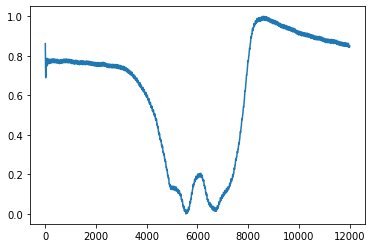

In [ ]:
#Plot Graph of gesture 

from matplotlib import pyplot as plt

#To create a time array between range <-- used for plotting 
time_array = []
for n in range(0,12000):
  time_array.append(n)

#Choose the gesture index to plot
gesture_index = 100

graph = normDF.iloc[:, gesture_index].values
plt.plot(time_array,graph)

In [ ]:
transposed_normDF = normDF.transpose()
df_label = df.loc[:,['label']].values
label = df_label
transposed_normDF['label'] = label
transposed_normDF

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,11961,11962,11963,11964,11965,11966,11967,11968,11969,11970,11971,11972,11973,11974,11975,11976,11977,11978,11979,11980,11981,11982,11983,11984,11985,11986,11987,11988,11989,11990,11991,11992,11993,11994,11995,11996,11997,11998,11999,label
gesture0,1.000000,0.998999,0.992136,0.985392,0.981485,0.979230,0.971123,0.959453,0.948148,0.936316,0.926181,0.915457,0.902762,0.894569,0.884707,0.876888,0.867978,0.858535,0.851306,0.844736,0.839925,0.836269,0.835018,0.834821,0.834015,0.836094,0.840032,0.844201,0.849027,0.853677,0.857778,0.861829,0.865535,0.869257,0.872465,0.874302,0.876365,0.877280,0.877198,0.876308,...,0.915728,0.915831,0.915532,0.914960,0.914309,0.913555,0.912661,0.911462,0.910444,0.909104,0.907793,0.906474,0.905112,0.903865,0.902886,0.902109,0.901475,0.900897,0.900591,0.900931,0.901451,0.902111,0.902922,0.903785,0.904654,0.905672,0.906567,0.907629,0.908390,0.909122,0.909670,0.909927,0.909920,0.909624,0.908912,0.908136,0.907435,0.906641,0.905826,0
gesture1,0.830369,0.820952,0.829090,0.840101,0.849959,0.856079,0.866664,0.878832,0.886894,0.894908,0.904293,0.912193,0.919360,0.925268,0.929110,0.933836,0.935981,0.939626,0.939623,0.937720,0.935538,0.931400,0.927269,0.921163,0.914676,0.909158,0.903839,0.897282,0.891302,0.885643,0.879658,0.873343,0.868135,0.864173,0.861786,0.859623,0.858044,0.857629,0.858483,0.860597,...,0.903020,0.903896,0.905079,0.905955,0.906727,0.907195,0.907240,0.906974,0.906469,0.905625,0.904833,0.904020,0.902815,0.901770,0.900288,0.899105,0.897608,0.896050,0.894553,0.893402,0.892376,0.891770,0.891141,0.890706,0.890688,0.891219,0.892161,0.892839,0.893823,0.894791,0.895401,0.896321,0.897305,0.898140,0.898699,0.899358,0.899801,0.899724,0.899368,0
gesture2,0.804591,0.803786,0.794141,0.791864,0.792729,0.795959,0.800897,0.803806,0.809295,0.813902,0.819583,0.825335,0.831878,0.840460,0.848262,0.856520,0.863600,0.869657,0.875314,0.882404,0.888806,0.892037,0.895702,0.898420,0.900395,0.901387,0.900523,0.898129,0.894563,0.890544,0.886966,0.883058,0.878182,0.874345,0.869702,0.865782,0.861258,0.856455,0.852567,0.849798,...,0.916539,0.917472,0.918411,0.918861,0.919073,0.919124,0.919028,0.918518,0.917705,0.916605,0.915584,0.914601,0.913428,0.912208,0.910912,0.909349,0.907752,0.906524,0.905449,0.904626,0.903897,0.903391,0.903240,0.903542,0.904128,0.904727,0.905550,0.906312,0.907164,0.908100,0.908870,0.909713,0.910348,0.910925,0.911390,0.911599,0.911491,0.910931,0.910145,0
gesture3,0.723090,0.720819,0.724736,0.734288,0.746266,0.757249,0.766716,0.777689,0.793694,0.808094,0.821817,0.835245,0.846025,0.856316,0.865260,0.872403,0.879444,0.885252,0.889005,0.891812,0.892564,0.892585,0.890423,0.886518,0.883173,0.880220,0.877122,0.873316,0.870456,0.868840,0.867726,0.866959,0.866522,0.867188,0.868306,0.869089,0.871264,0.874895,0.878371,0.880727,...,0.916485,0.915777,0.914990,0.914285,0.913555,0.913172,0.912823,0.912460,0.912381,0.912524,0.912610,0.912907,0.913384,0.914197,0.915321,0.916521,0.917439,0.918615,0.919896,0.920993,0.921861,0.922919,0.923661,0.924476,0.924909,0.925076,0.924761,0.924432,0.923704,0.923049,0.922264,0.921075,0.919819,0.918539,0.917151,0.915544,0.914037,0.912493,0.911397,0
gesture4,0.879138,0.881928,0.877142,0.864970,0.852743,0.846938,0.838234,0.836060,0.831493,0.831596,0.834608,0.836642,0.840573,0.843169,0.848358,0.854844,0.860780,0.866829,0.874581,0.882005,0.889681,0.895354,0.901552,0.906969,0.911321,0.915651,0.918996,0.921600,0.921991,0.921904,0.920624,0.918816,0.916206,0.912031,0.908362,0.904926,0.900065,0.896156,0.891452,0.886683,...,0.926590,0.927548,0.928306,0.928421,0.928419,0.928118,0.927610,0.926880,0.926099,0.924972,0.923670,0.922516,0.920981,0.919586,0.918382,0.917006,0.915926,0.914785,0.914006,0.913282,0.912463,0.912132,0.912437,0.912949,0.913469,0.914362,0.915280,0.916348,0.917212,0.918129,0.918990,0.920027,0.920738,0.921222,0.921378,0.921430,0.921170,0.920671,0.919908,0
...,...,...,...

In [ ]:
#Find mumber of principle components for 99% variance 

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
features = [str(i) for i in range(0,12000)]

transposed_normDF.columns = transposed_normDF.columns.map(str)

x = transposed_normDF.loc[:, features].values
y = transposed_normDF.loc[:,['label']].values

wanted_explained_variance_ratio = 0.99
steps_down = 1
wanted_n_components = x.shape[1]
first_time = True

for i in range(30, 0, -steps_down):
  total_var_ratio = round(np.sum(PCA(n_components=i).fit(x).explained_variance_ratio_), 5)
  print('i =', i, 'with a variance ratio of', total_var_ratio)
  if total_var_ratio < wanted_explained_variance_ratio and first_time:
    wanted_n_components = i + steps_down
    first_time = False
    # break

print("We should set n_components to: ", wanted_n_components)

i = 30 with a variance ratio of 0.99927
i = 29 with a variance ratio of 0.99919
i = 28 with a variance ratio of 0.99908
i = 27 with a variance ratio of 0.99896
i = 26 with a variance ratio of 0.99882
i = 25 with a variance ratio of 0.99865
i = 24 with a variance ratio of 0.99848


KeyboardInterrupt: ignored

In [ ]:
#Apply PCA 

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

transposed_normDF.columns = transposed_normDF.columns.map(str)
features = [str(i) for i in range(0,12000)]
x = transposed_normDF.loc[:, features].values
y = transposed_normDF.loc[:,['label']].values

pca = PCA(n_components=0.99)
principalComponents = pca.fit_transform(x)

import pickle
# save the classifier
with open('/content/drive/MyDrive/Masters Final Code/Extra/pca.pkl', 'wb') as fid:
    pickle.dump(pca, fid) 

pc = pca.explained_variance_ratio_.cumsum()
x1 = StandardScaler().fit_transform(principalComponents)
full_newdf = pd.DataFrame(data = x1
             , columns = [f'pc_stdscaled_{i}' for i in range(len(pc))])
full_finalDf = pd.concat([full_newdf, df[['label']]], axis = 1)
print(full_finalDf)
print(full_newdf.shape)

      pc_stdscaled_0  pc_stdscaled_1  ...  pc_stdscaled_14  label
0           1.366140       -0.522394  ...         1.008495      0
1           1.527681       -0.271857  ...         3.307478      0
2           1.212411        0.157525  ...        -0.103812      0
3           1.446997       -0.239583  ...         0.663721      0
4           1.594918       -0.527705  ...        -0.938883      0
...              ...             ...  ...              ...    ...
1044       -0.834745        0.190272  ...        -0.391056      4
1045       -0.603965       -0.813570  ...        -1.141311      4
1046       -0.192438       -0.879349  ...        -0.613773      4
1047       -0.768363       -0.181243  ...        -1.929741      4
1048       -0.912458       -0.521086  ...         0.050155      4

[1049 rows x 16 columns]
(1049, 15)


In [ ]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, df) -> None:
        super().__init__()
        self.y = torch.unsqueeze(torch.tensor(df.pop('label').values, dtype=torch.long), dim=-1)
        self.X = torch.unsqueeze(torch.tensor(df.iloc[:,:].values, dtype=torch.float32), dim=-1)
        # self.X = torch.tensor(df.iloc[:,:].values, dtype=torch.float32)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
    def __len__(self):
        return len(self.y)

In [ ]:
init_data = MyDataset(full_finalDf)
n = len(init_data)
lengths = [int(n*0.8), n-int(n*0.8)]
train_set, val_set = random_split(init_data, lengths=lengths)


In [ ]:
train_loader = torch.utils.data.DataLoader(train_set, shuffle=True, batch_size=8)
val_loader = torch.utils.data.DataLoader(val_set, shuffle=True, batch_size=8)

In [ ]:
x,y = next(iter(train_loader))
print(x.shape)
print(y.shape)

torch.Size([32, 15, 1])
torch.Size([32, 1])


In [ ]:
#CNN MODEL

class Simple1DCNN(torch.nn.Module):
    def __init__(self,n_neurons):
        super(Simple1DCNN, self).__init__()
        self.layer1 = torch.nn.Conv1d(in_channels=15, out_channels=n_neurons, kernel_size=1, stride=2)
        # self.layer1 = torch.nn.Conv1d(in_channels=12000, out_channels=n_neurons, kernel_size=1, stride=2)
        self.act1 = torch.nn.ReLU()
        self.layer2 = torch.nn.Conv1d(in_channels=n_neurons, out_channels=5, kernel_size=1)
    def forward(self, x):
        x = self.layer1(x)
        x = self.act1(x)
        x = self.layer2(x)

        log_probs = torch.nn.functional.log_softmax(x, dim=1)

        return log_probs

In [ ]:
def model_pipeline(config=None):

    # tell wandb to get started
    with wandb.init(project="pytorchcnn", config=config, reinit=True):
      # access all HPs through wandb.config, so logging matches execution!
      config = wandb.config

      # make the model, data, and optimization problem
      model, criterion, optimizer = make(config)
      print(model)

      # and use them to train the model
      train(model, train_loader, criterion, optimizer, config)

      # and test its final performance
      test(model, val_loader)

    return model

def make(config):
    # Make the model
    model = Simple1DCNN(config.n_neurons).to(device)

    # Make the loss and optimizer
    criterion = nn.CrossEntropyLoss()
    if config.optimizer == "sgd":
        optimizer = torch.optim.SGD(model.parameters(),
                              lr=config.learning_rate, momentum=0.9)
    elif config.optimizer == "adam":
        optimizer = torch.optim.Adam(model.parameters(),
                               lr=config.learning_rate)
    elif config.optimizer == "adaBound":
        optimizer = AdaBound(model.parameters(),
                               lr=config.learning_rate)
    # optimizer = torch.optim.Adam(
    #     model.parameters(), lr=config.learning_rate)
    
    return model, criterion, optimizer

def train(model, loader, criterion, optimizer, config):
    # tell wandb to watch what the model gets up to: gradients, weights, and more!
    wandb.watch(model, criterion, log="all", log_freq=10)

    # Run training and track with wandb
    total_batches = len(loader) * config.epochs
    example_ct = 0  # number of examples seen
    batch_ct = 0
    for epoch in tqdm(range(config.epochs)):
        for _, (images, labels) in enumerate(loader):

            loss = train_batch(images, labels, model, optimizer, criterion)
            example_ct +=  len(images)
            batch_ct += 1

            # Report metrics every 25th batch
            if ((batch_ct + 1) % 25) == 0:
                train_log(loss, example_ct, epoch)


def train_batch(images, labels, model, optimizer, criterion):
    images, labels = images.to(device), labels.to(device)
    
    # Forward pass ➡
    outputs = model(images)
    loss = criterion(outputs, labels)
    
    # Backward pass ⬅
    optimizer.zero_grad()
    loss.backward()

    # Step with optimizer
    optimizer.step()

    return loss

def train_log(loss, example_ct, epoch):
    loss = float(loss)

    # where the magic happens
    wandb.log({"epoch": epoch, "loss": loss}, step=example_ct)
    print(f"Loss after " + str(example_ct).zfill(5) + f" examples: {loss:.3f}")

def test(model, test_loader):
    model.eval()

    # Run the model on some test examples
    with torch.no_grad():
        correct, total = 0, 0
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print(f"Accuracy of the model on the {total} " +
              f"test gestures: {100 * correct / total}%")
        
        wandb.log({"test_accuracy": correct / total})


# model = model_pipeline(config)
wandb.agent(sweep_id, model_pipeline, count=100)

wandb: Agent Starting Run: 6ontf3iz with config:
wandb: 	epochs: 120
wandb: 	learning_rate: 0.01765
wandb: 	n_neurons: 400
wandb: 	optimizer: adaBound
wandb: Ctrl + C detected. Stopping sweep.
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


In [ ]:
n_neurons = 400
model = Simple1DCNN(n_neurons)
print(model)

Simple1DCNN(
  (layer1): Conv1d(15, 400, kernel_size=(1,), stride=(2,))
  (act1): ReLU()
  (layer2): Conv1d(400, 5, kernel_size=(1,), stride=(1,))
)


In [ ]:
EPOCHS = 120
lr = 0.01765
# optimizer = torch.optim.Adam(model.parameters(),lr=lr)
optimizer = AdaBound(model.parameters(),lr=lr)

loss_fn = nn.CrossEntropyLoss()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


import time
start = time.time()

for i in range(EPOCHS):
    total_loss = 0
    model.train()
    model.to(device)
    for j, (data, label) in enumerate(train_loader):
        out = model(data.to(device))
        # print(out.shape)
        # print(label.shape)
        # break
        loss = loss_fn(out, label.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
      # getting training quality data
        current_loss = loss.item()
        total_loss += current_loss 
    print(i, total_loss/len(train_loader))

end = time.time()
print(end - start)

Loss after 05418 examples: 0.037
0 0.8847966569441336
Loss after 06193 examples: 0.037
1 0.4652192614696644
Loss after 06968 examples: 0.040
2 0.2850723959229611
Loss after 07743 examples: 0.055
3 0.21822633925411436
Loss after 08518 examples: 0.055
4 0.19831478443962555
Loss after 09293 examples: 0.030
5 0.142565470740751
Loss after 10068 examples: 0.151
6 0.09783600525999511
Loss after 10868 examples: 0.038
7 0.0694648626225966
Loss after 11643 examples: 0.037
8 0.05437569085646559
Loss after 12418 examples: 0.018
9 0.04701831812659899
Loss after 13193 examples: 0.008
10 0.04822598873741097
Loss after 13968 examples: 0.037
11 0.042730440903041095
12 0.038181699708931975
Loss after 14743 examples: 0.015
13 0.03652752252916495
Loss after 15518 examples: 0.011
14 0.03337349221800213
Loss after 16293 examples: 0.028
15 0.02794134109798405
Loss after 17068 examples: 0.026
16 0.029448336507711146
Loss after 17843 examples: 0.014
17 0.02612621216448369
Loss after 18618 examples: 0.011
18 0.

In [ ]:
torch.save(model, '/content/drive/MyDrive/Masters Final Code/Extra/MODEL_CNN.pt')

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix


array_predicted = torch.tensor([])
array_labels =  torch.tensor([])

val_loss = 0
precision, recall, f1, accuracy = [], [], [], []
model.eval()
with torch.no_grad():
    for i,(data, label) in enumerate(val_loader):
        #print(data.shape)
        # print(label)        
        outputs = model(data.to(device))
        # print(outputs.shape)
        # break
        val_loss += loss_fn(outputs, label.to(device))
        #print(val_loss/(i+1))

        predicted_classes = torch.max(outputs, 1)[1] # get class from network's prediction
        # print(label)
        # print(predicted_classes)

        array_predicted = torch.cat((array_predicted.cpu(),predicted_classes.cpu()),0) 
        array_labels = torch.cat((array_labels.cpu(), label.cpu()),0)
        
        
        # calculate P/R/F1/A metrics for batch
        for acc, metric in zip((precision, recall, f1), 
                                (precision_score, recall_score, f1_score)):
            acc.append(
                metric(label.cpu(), predicted_classes.cpu(), average="macro")
            )
        accuracy.append(accuracy_score(label.cpu(), predicted_classes.cpu()))


In [ ]:
acc = accuracy_score(array_predicted, array_labels)
precision = precision_score(array_labels, array_predicted, average='macro')
recall = recall_score(array_labels, array_predicted, average='macro')
f1 = f1_score(array_labels, array_predicted, average='macro')
print(f"Accuracy: {int(acc * 100.)}%")
print(f"Precision: {int(precision * 100.)}%")
print(f"Recall: {int(recall * 100.)}%")
print(f"F-Score: {int(f1 * 100.)}%")

cm = confusion_matrix(array_labels, array_predicted)
cm  

Accuracy: 91%
Precision: 91%
Recall: 91%
F-Score: 91%


array([[44,  0,  0,  0,  0],
       [ 1, 42,  0,  0,  1],
       [ 0,  0, 34,  0,  2],
       [ 0,  0,  1, 40,  4],
       [ 0,  0,  2,  6, 33]])

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(array_labels, array_predicted)
cm

array([[44,  0,  0,  0,  0],
       [ 1, 42,  0,  0,  1],
       [ 0,  0, 34,  0,  2],
       [ 0,  0,  1, 40,  4],
       [ 0,  0,  2,  6, 33]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

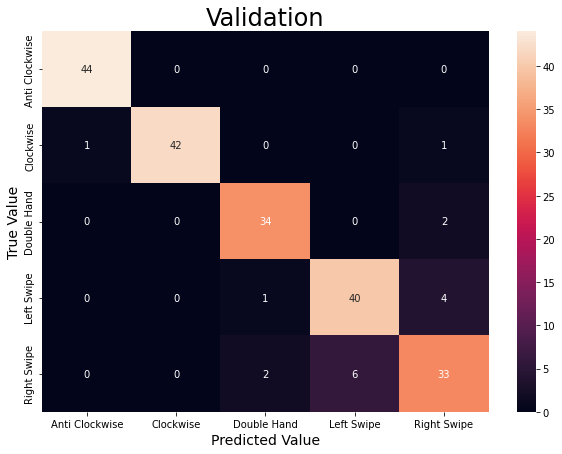

In [ ]:
labels=['Anti Clockwise', 'Clockwise', 'Double Hand', 'Left Swipe', 'Right Swipe']

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sn
plt.figure(figsize=(10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted Value',fontsize=14)
plt.ylabel('True Value',fontsize=14)
plt.title('Validation',fontsize=24)
plt.xticks(np.arange(5)+0.5,labels)
plt.yticks(np.arange(5)+0.5,labels)

from google.colab import files
plt.savefig("ValidationCNN.png")
files.download("ValidationCNN.png")
#gesture_list = ["anti-clockwise","clockwise","Double Hand", "Left Swipe", "Right Swipe"]